In [10]:
# import libraries 
%pylab inline
import tradingWithPython as twp
import pandas as pd
twp.extra.setNotebookStyle()
figsize(10,5)

Populating the interactive namespace from numpy and matplotlib


/home/jev/anaconda3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plotting', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


<img src="files/img/cover_sheet.svg">


# Outline

* Intro
    
* Scientific Python tools
   
* Getting data
 
* Example strategy
 




# About 

* Programming since 1992 
* Background in Applied Physics (TU Delft)
* Working at Oce since 2005
    * algorithm development
    * machine visioin
    * image processing
    
* Trading stocks as a hobby since 2009
    * see my adventures at [tradingWithPython blog](http://tradingwithpython.blogspot.com)



# Why Python

* Perfect all-round tool
    * (web) application development
    * scientific calculations
    * massive community

# Scientific python  - dev tools

(see [http://github.com/jrjohansson/scientific-python-lectures](http://github.com/jrjohansson/scientific-python-lectures) for more)


* IPython - interactive python - **hacking**
* Jupyter Notebook - code & document - fantastic **research** tool
* Spyder - IDE - good **development** tool
* Eclipse & others - **engineering** tools 





# Libraries - general

* numpy - matlab-like matrix calculations
* scipy - scientific libraries (interpolation, transformations etc)
* [scikit-learn](http://scikit-learn.org/stable/) - machine learning 
* [keras](https://keras.io/) - deep learning



# Libraries - Finance

* [pandas](http://pandas.pydata.org/) - data analysys library
* [trading-with-python](https://github.com/sjev/trading-with-python) - my toolbox
* [zipline](http://www.zipline.io/) - backtesting (I don't use it)
* ibpy - interfacing with InteractiveBrokers API

## Jupyter notebook
( previously called IPython notebook )
Project found on [jupyter.org](http://jupyter.org)

* Combine code, equations, visualisations , html etc
* Explore & document
* Share with others

<img src="img/jupyterpreview.png" width="800">


## Spyder

[Spyder](http://code.google.com/p/spyderlib/) is a MATLAB-like IDE for scientific computing with python. It has the many advantages of a traditional IDE environment, for example that everything from code editing, execution and debugging is carried out in a single environment, and work on different calculations can be organized as projects in the IDE environment.

<!-- <img src="files/images/spyder-screenshot.jpg" width="800"> -->
<img src="img/spyder-screenshot.jpg" width="800">

Some advantages of Spyder:

* Powerful code editor, with syntax high-lighting, dynamic code introspection and integration with the python debugger.
* Variable explorer, IPython command prompt.
* Integrated documentation and help.

# Plotting

* matplotlib - Matlab plotting clone
* bokeh - interactive javascript plots (see [tutorial](https://github.com/bokeh/bokeh-notebooks/tree/master/tutorial) )

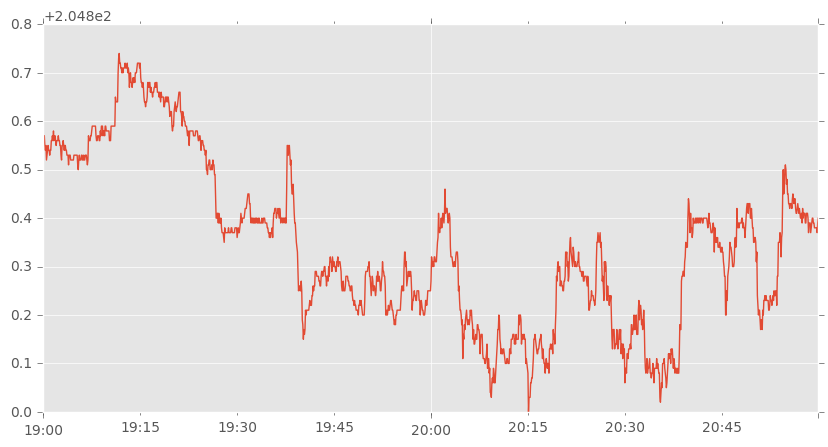

In [16]:
# matplotlib example 
# plot 5-sec data
price = pd.DataFrame.from_csv('data/SPY_20160411205955.csv')
price.close.plot()

In [33]:
# bokeh example
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.charts import Line
output_notebook()


line = Line(price.close, plot_width=800, plot_height=400)
show(line)

Loading BokehJS ...

# Getting the data

## Yahoo Finance
* free daily OHLC data

## Interactive Brokers
* free (for clients) intraday data 

## Quantdl
* subscription packages, easy interface  

Got 6013 days of data


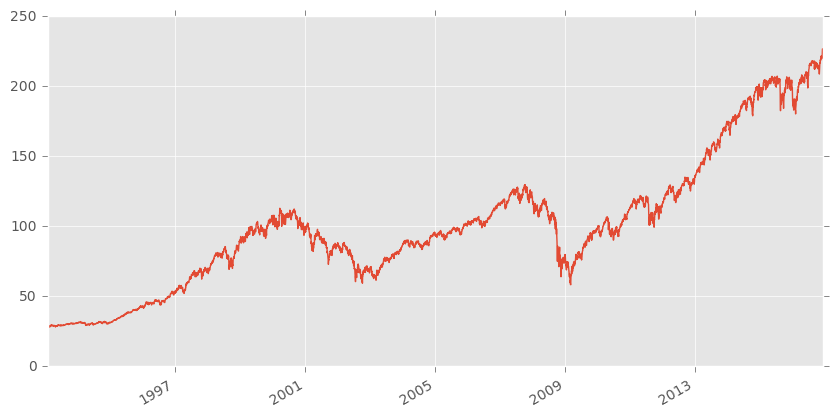

In [11]:
# get data from yahoo finance
price = twp.yahooFinance.getHistoricData('SPY')

price['adj_close'].plot()

# Interactive brokers

* has descent API for historic & realtime data and order submission
* provides data down to 1 s resolution
* historic data - see [downloader code]( https://github.com/sjev/trading-with-python/blob/master/tools/getHistData/getData.py)
* realtime quotes - see [tick logger](https://github.com/sjev/trading-with-python/blob/master/tools/tickLogger/tickLogger.py) 


# Simple volatility strategy

* trade VXX
* use VIX-VXV as inidicator 
* *very* simple approximation
    * no transaction cost
    * simple summation of percent returns
    
    
... this one actually makes money. 


**Disclaimer** : you *will* lose money.  Don't blame me for anything. 

In [19]:
# get data 
import tradingWithPython.lib.cboe as cboe # cboe data

symbols = ['SPY','VXX','VXZ']
priceData = twp.yahooFinance.getHistoricData(symbols).minor_xs('adj_close')
volData  = cboe.getHistoricData(['VIX','VXV']).dropna()

 [*********************100%***********************]  3 of 3 completeDownloading VIX from http://www.cboe.com/publish/ScheduledTask/MktData/datahouse/vixcurrent.csv


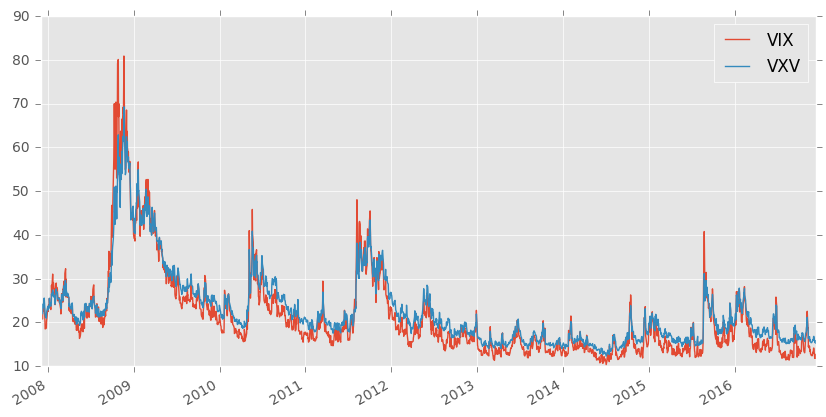

In [43]:
volData.plot();

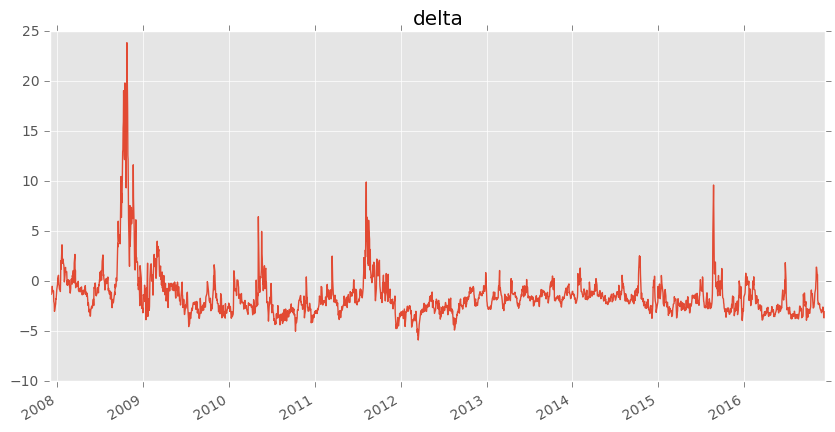

In [37]:

delta = volData.VIX - volData.VXV
delta.plot()
title('delta')

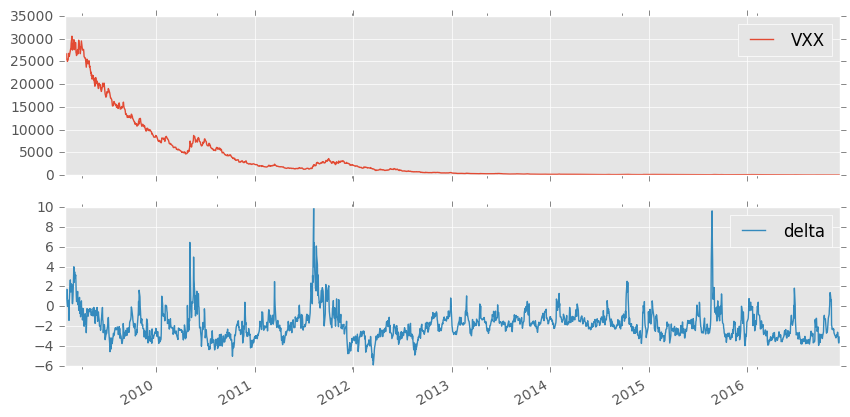

In [44]:
# prepare data

df = pd.DataFrame({'VXX':priceData.VXX, 'delta':delta}).dropna()
df.plot(subplots='True');

In [119]:
# strategy simulation function

def backtest(thresh):
    """ backtest strategy with a threshold value"""

    df['dir'] = 0 # init with zeros
    df['ret'] = df.VXX.pct_change()

    long = df.delta > thresh
    short = df.delta < thresh
    #df.ix[long,'dir'] = 1 # set long positions
    df.ix[short,'dir'] = -1 # set short positions

    df['dir'] = df['dir'].shift(1) # dont forget to shift one day forward!

    df['pnl'] = df['dir'] * df['ret']
    return df

df = backtest(0)
df

,VXX,delta,dir,ret,pnl
2009-01-30,26772.48,0.24,NaN,NaN,NaN
2009-02-02,26688.00,1.61,0.0,-3.16e-03,-0.00e+00
2009-02-03,25438.72,0.82,0.0,-4.68e-02,-0.00e+00
2009-02-04,25533.44,1.72,0.0,3.72e-03,0.00e+00
2009-02-05,25377.28,1.13,0.0,-6.12e-03,-0.00e+00
...,...,...,...,...,...
2016-12-06,26.15,-3.69,-1.0,-3.26e-02,3.26e-02
2016-12-07,26.22,-3.26,-1.0,2.68e-03,-2.68e-03
2016-12-08,26.28,-3.08,-1.0,2.29e-03,-2.29e-03
2016-12-09,25.97,-3.47,-1.0,-1.18e-02,1.18e-02


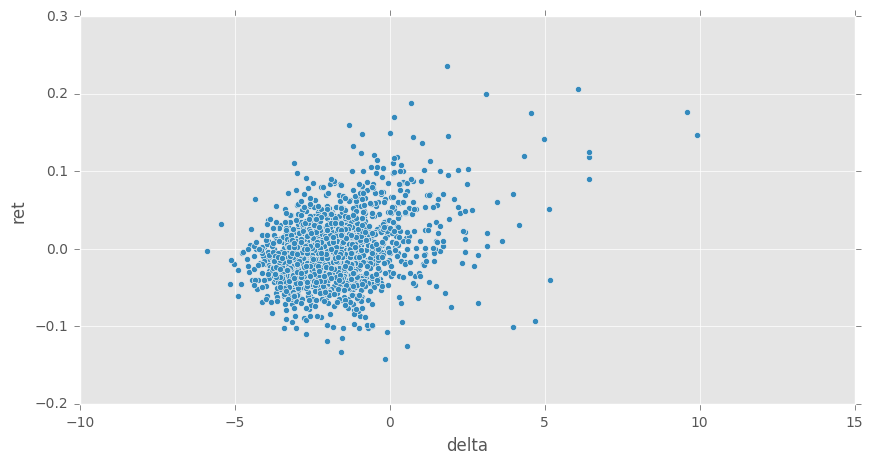

In [114]:
# check relationship delta-returns
df.plot(kind='scatter',x='delta',y='ret')

## Do a parameter scan

... simulate for different values of `thresh` variable

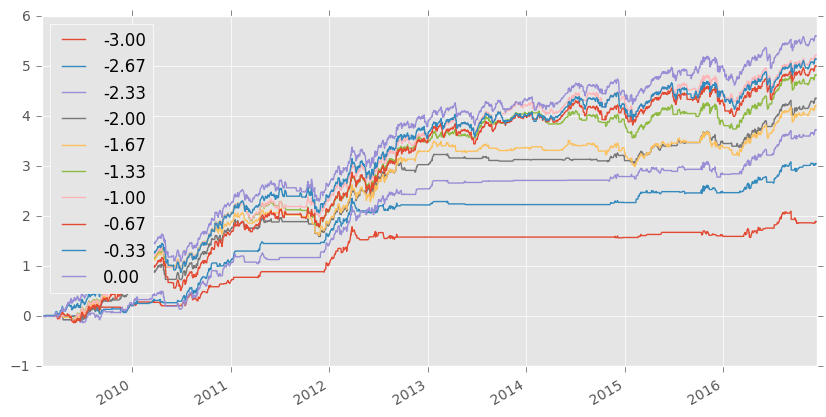

In [123]:
T = np.linspace(-3,0,10)
h = ['%.2f' % t  for t in T] # make table header
pnl ={} # pnl dict

PNL = pd.DataFrame(index=df.index, columns=h)

for i, t in enumerate(T):
    PNL[h[i]] = backtest(thresh=t)['pnl']


PNL.cumsum().plot()

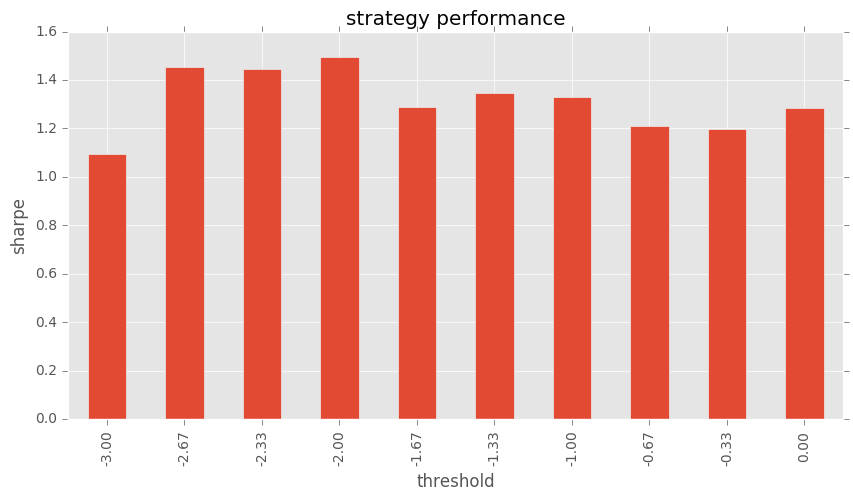

In [124]:
# evaluate performance
twp.sharpe(PNL).plot(kind='bar')
xlabel('threshold')
ylabel('sharpe')
title('strategy performance')

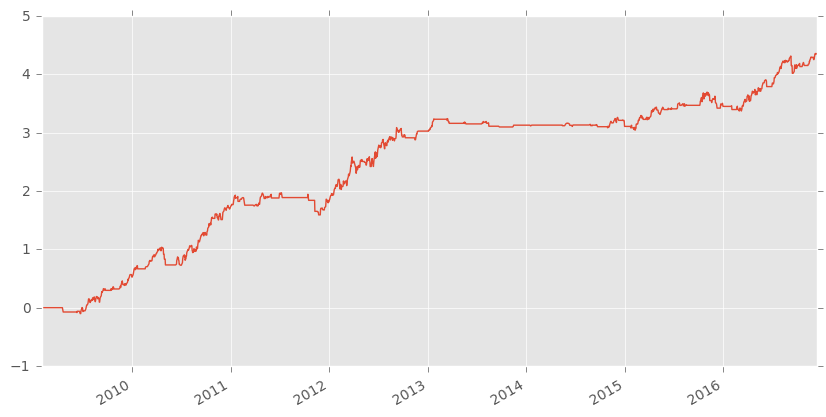

In [125]:
# plot best strategy
PNL['-2.00'].cumsum().plot()